<a href="https://colab.research.google.com/github/dvelasquev/IA/blob/main/Lecture09/notebooks/L09_CNN_Transfer_pytorch_hf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision - Diego Velásquez Varla


## Preliminares

In [ ]:
!pip install datasets

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import torch
import torch.cuda.amp as amp
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import Counter
from datasets import load_dataset
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from timm import create_model  # Se asume que se usará create_model u otro
import torchvision
import torchvision.models as models
from torchvision import transforms
from torchvision.transforms import RandAugment
from torch import nn  # Redundante con import torch.nn as nn, puede omitirse
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import DataLoader, Dataset, Subset
from typing import Callable, Iterator, List, Optional


sns.set_style("whitegrid")

def show_image(img, title=None):
    img = img.detach().cpu()
    img = img.permute((1, 2, 0)).numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean   # unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.gca().tick_params(axis="both", which="both", bottom=False, left=False, labelbottom=False, labelleft=False)
    if title is not None:
        plt.title(title)

## Configuración de la base de datos

In [32]:
# --- ImageNet normalization
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]
default_imagenet_normalization = transforms.Normalize(mean=imagenet_mean, std=imagenet_std)

# --- Transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.25, 1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    default_imagenet_normalization,
])
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    default_imagenet_normalization,
])

# Step 1: Load dataset
hf_dataset = load_dataset("flwrlabs/caltech101", split="train")  # all in one split

# Step 2: Count class occurrences
label_counts = Counter(hf_dataset['label'])

# Step 3: Keep only classes with ≤100 samples
keep_classes = sorted([label for label, count in label_counts.items() if count <= 100])

# Step 4: Subsample max 100 samples per class
indices = list(range(len(hf_dataset)))
random.shuffle(indices)

new_indices = []
class_counts = {i: 0 for i in keep_classes}

for i in indices:
    y = hf_dataset[i]['label']
    if y in keep_classes and class_counts[y] < 100:
        new_indices.append(i)
        class_counts[y] += 1

# Step 5: Translate labels
def translate_label(y, keep_classes):
    try:
        return keep_classes.index(y)
    except ValueError:
        return -1

labels = [translate_label(hf_dataset[i]['label'], keep_classes) for i in new_indices]
assert max(labels) == len(keep_classes) - 1

labels = np.array(labels)
# Step 6: Train-test split
test_size = 640
val_size = 640
train_size = len(new_indices) - test_size - val_size

# First, split into train+val and test
train_val_idx, test_idx = train_test_split(
    new_indices,
    test_size=test_size,
    stratify=labels,
    random_state=42
)

# Map from full dataset index to position in new_indices
idx_map = {idx: i for i, idx in enumerate(new_indices)}

# Get label indices for train_val
train_val_labels = np.array([labels[idx_map[i]] for i in train_val_idx])

# Then, split train+val into train and val
train_idx, val_idx = train_test_split(
    train_val_idx,
    test_size=val_size,
    stratify=train_val_labels,
    random_state=42
)

# --- Torch Dataset wrapper
class HFCaltech101(Dataset):
    def __init__(self, hf_dataset, indices, transform, keep_classes):
        self.hf_dataset = hf_dataset
        self.indices = indices
        self.transform = transform
        self.keep_classes = keep_classes

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        item = self.hf_dataset[self.indices[idx]]
        image = item['image'].convert('RGB')
        label = translate_label(item['label'], self.keep_classes)

        if self.transform:
            image = self.transform(image)
        return image, label

# --- Datasets and loaders
train_dataset = HFCaltech101(hf_dataset, train_idx, train_transform, keep_classes)
val_dataset = HFCaltech101(hf_dataset, val_idx, test_transform, keep_classes)
test_dataset = HFCaltech101(hf_dataset, test_idx, test_transform, keep_classes)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = 64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Un Vistazo Más Cercano al Conjunto de Datos

Primero, trazamos el tamaño de cada clase y observamos que la distribución de clases no es uniforme.

Luego, mostramos ejemplos aleatorios del conjunto de datos, anotados con la etiqueta de la clase y el índice.
Ten en cuenta que las imágenes de entrenamiento incluyen aumentos estándar que se utilizan típicamente en modelos de visión (definidos anteriormente).


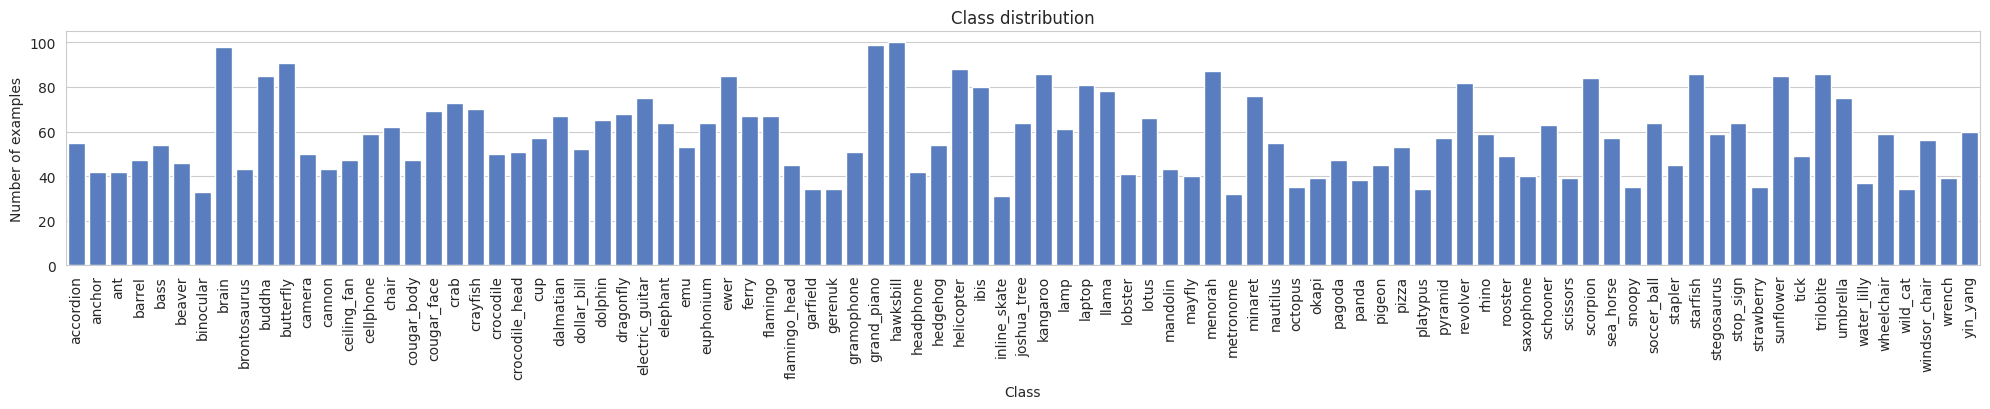



Train images (including augmentations):


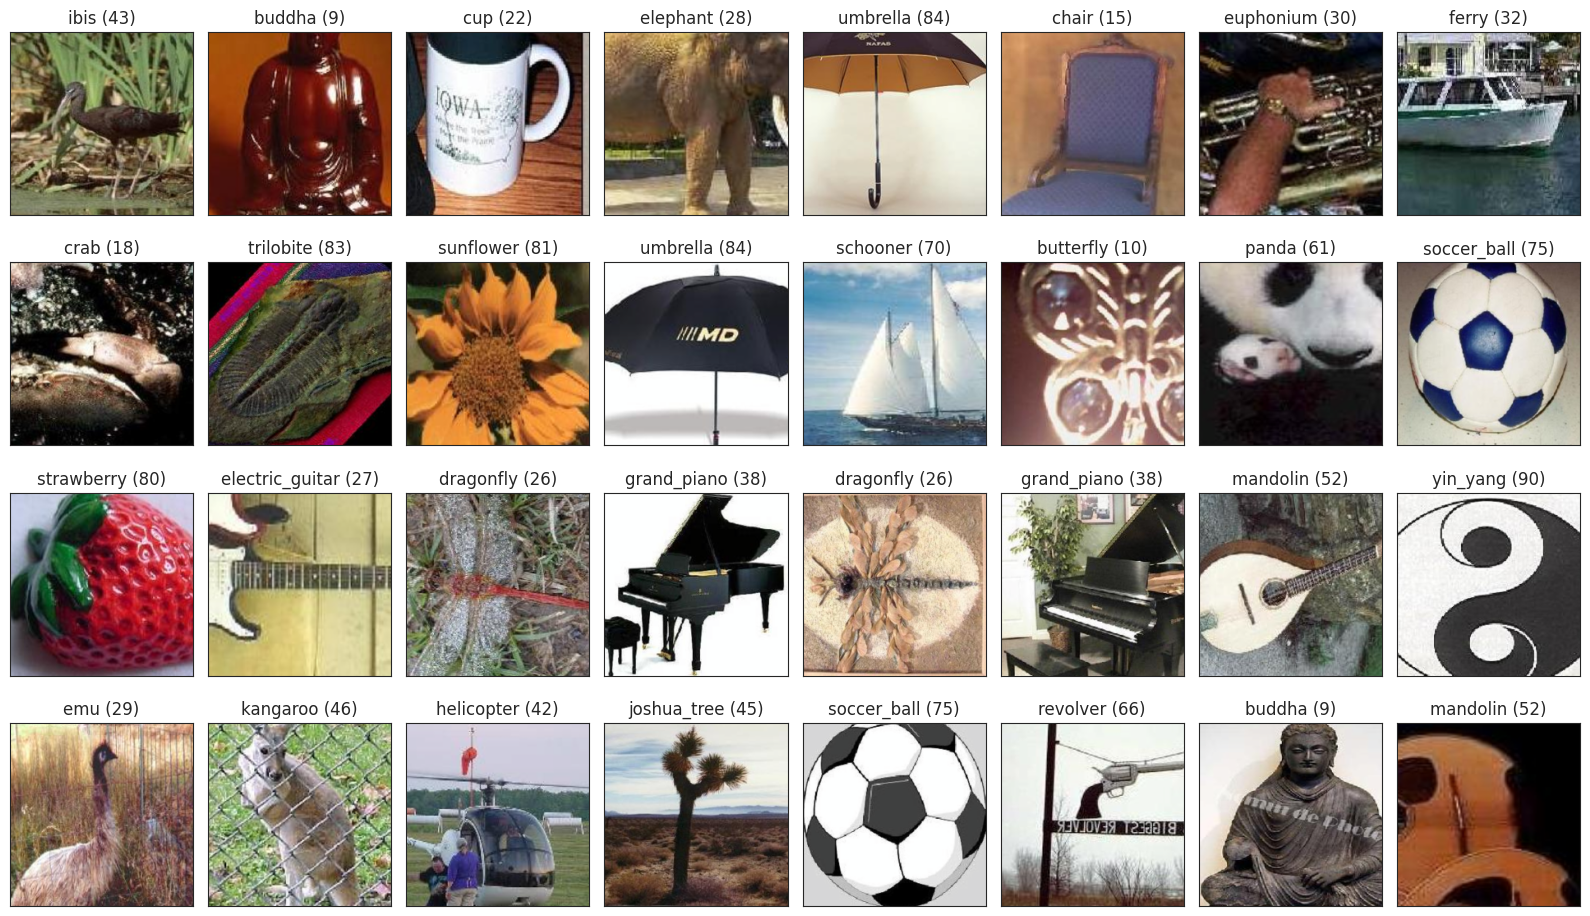



Train images (including augmentations):


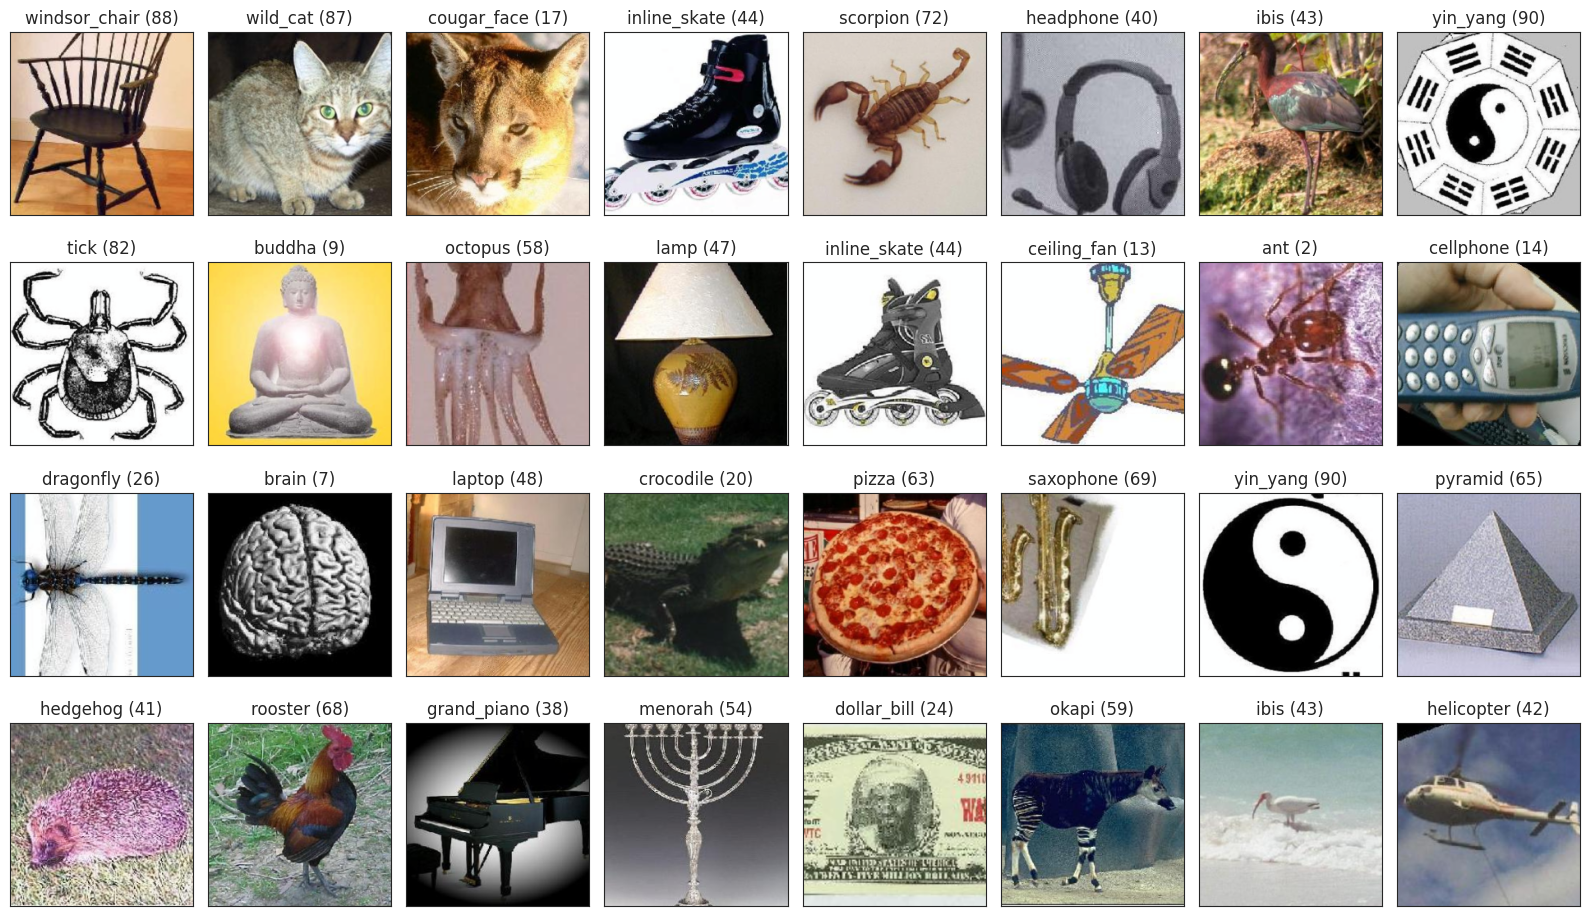



Test images:


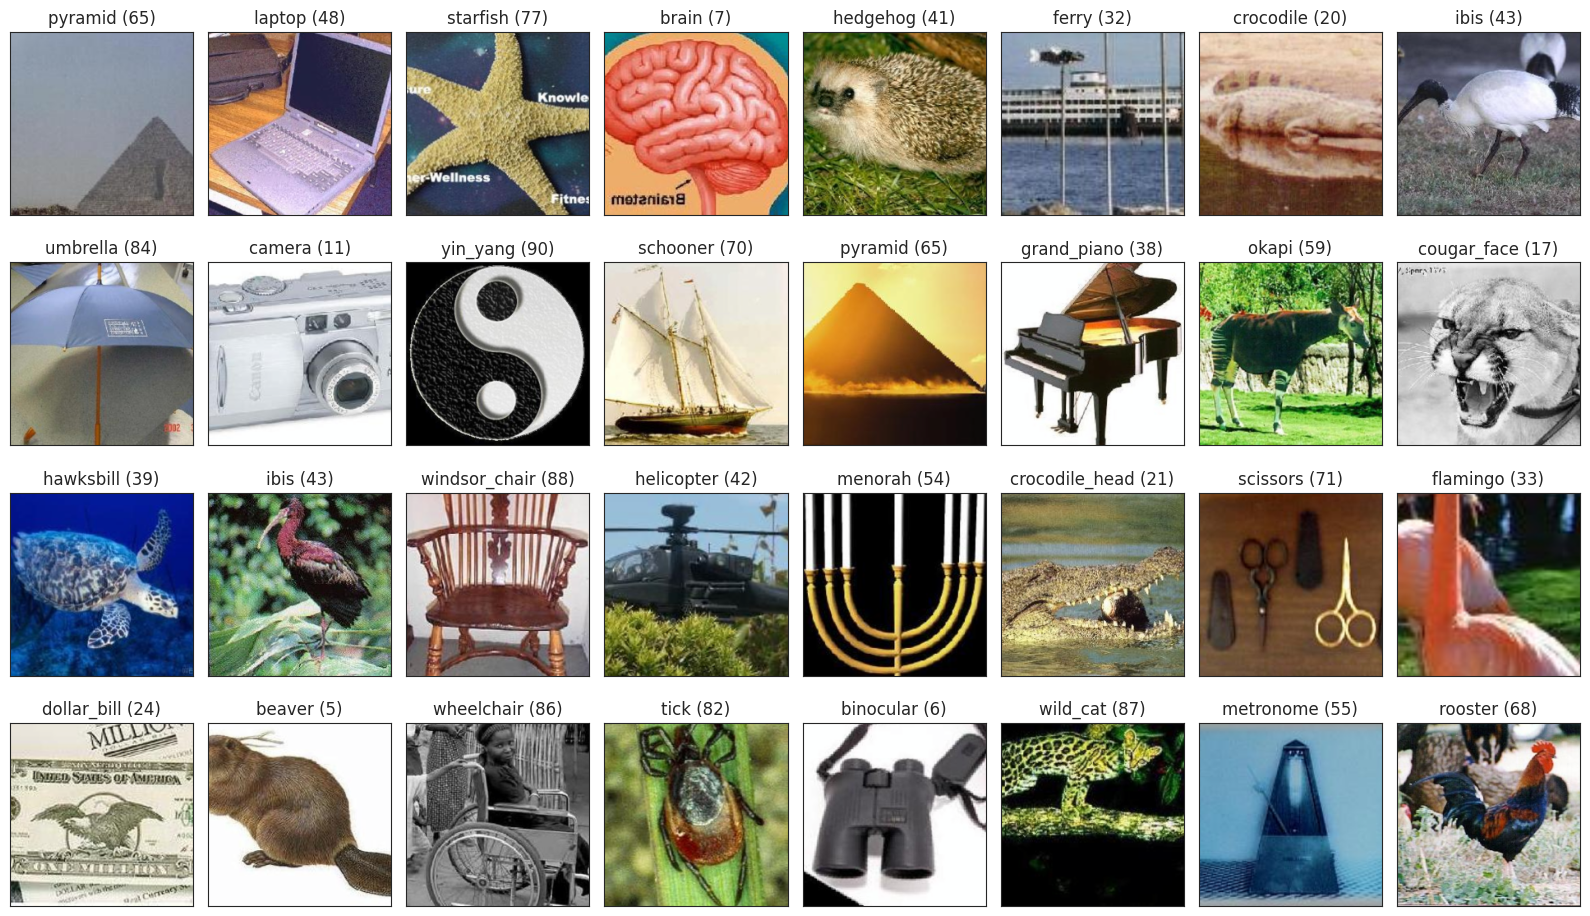

In [33]:
full_label_names = hf_dataset.features['label'].names
categories = [full_label_names[i] for i in keep_classes]

label_idxs, counts = np.unique(labels, return_counts=True)
plt.figure(figsize=(20, 4.2))
sns.barplot(
    x=[categories[label] for label in label_idxs],
    y=counts,
    color=sns.color_palette('muted')[0]
)
plt.xticks(rotation=90)
plt.xlabel("Class")
plt.ylabel("Number of examples")
plt.title("Class distribution")
plt.tight_layout()
plt.show()


def show_dataset_examples(dataloader):
    images, labels = next(iter(dataloader))
    with sns.axes_style("white"):
        fig, axes = plt.subplots(4, 8, figsize=(16, 9.5))
    axes = [ax for axes_ in axes for ax in axes_]   # flatten

    for j, (img, label) in enumerate(zip(images[:32], labels[:32])):
        plt.sca(axes[j])
        show_image(img, title=f"{categories[label.item()]} ({label.item()})")

    plt.tight_layout()
    plt.show()


print("\n\nTrain images (including augmentations):")
show_dataset_examples(train_loader)
print("\n\nTrain images (including augmentations):")
show_dataset_examples(val_loader)
print("\n\nTest images:")
show_dataset_examples(test_loader)

## Definir una Red Neuronal

**Asignación 1:** Adapta la CNN del laboratorio anterior (CIFAR-10) para manejar imágenes de 224x224. Recomendamos reducir significativamente el tamaño de los tensores antes de aplanarlos, añadiendo capas convolucionales con `stride > 1` o capas de [MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) (pero también puedes considerar [AvgPool2d](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html)).


In [34]:
# Asignación 1: CNN desde cero para imágenes 3×224×224 (sin errores)

# 1. Parámetros globales
NUM_CLASSES = len(np.unique(labels))
device      = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2. Transformaciones (incluye RandAugment)
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]
normalization = transforms.Normalize(imagenet_mean, imagenet_std)

train_transform = transforms.Compose([
    transforms.RandAugment(num_ops=2, magnitude=9),
    transforms.RandomResizedCrop(224, scale=(0.25, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalization,
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalization,
])

# 3. Bloque de convolución separable
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super().__init__()
        self.depthwise = nn.Conv2d(in_ch, in_ch, kernel_size=3,
                                   stride=stride, padding=1,
                                   groups=in_ch, bias=False)
        self.pointwise = nn.Conv2d(in_ch, out_ch, kernel_size=1,
                                   stride=1, padding=0, bias=False)
        self.bn = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        return self.relu(x)

# 4. Bloque residual con Squeeze-and-Excitation
class SEResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1, reduction=16):
        super().__init__()
        self.conv1 = DepthwiseSeparableConv(in_ch, out_ch, stride)
        self.conv2 = DepthwiseSeparableConv(out_ch, out_ch, 1)
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(out_ch, out_ch // reduction, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch // reduction, out_ch, 1),
            nn.Sigmoid()
        )
        if stride != 1 or in_ch != out_ch:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_ch)
            )
        else:
            self.shortcut = nn.Identity()
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        w   = self.se(out)
        out = out * w
        return self.relu(out + self.shortcut(x))

# 5. Definición del modelo completo
class Model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Stem inicial
        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2, padding=1),
        )
        # Bloques residuales
        self.layer1 = self._make_layer(32,  32,  3, stride=1)
        self.layer2 = self._make_layer(32,  64,  4, stride=2)
        self.layer3 = self._make_layer(64, 128,  6, stride=2)
        self.layer4 = self._make_layer(128,256,  3, stride=2)
        # Cabeza
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc      = nn.Linear(256, num_classes)
    def _make_layer(self, in_ch, out_ch, blocks, stride):
        layers = [SEResidualBlock(in_ch, out_ch, stride)]
        for _ in range(1, blocks):
            layers.append(SEResidualBlock(out_ch, out_ch, 1))
        return nn.Sequential(*layers)
    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x).view(x.size(0), -1)
        return self.fc(x)

# 6. Instanciar y probar forward
model = Model(num_classes=NUM_CLASSES).to(device)
dummy = torch.randn(2, 3, 224, 224, device=device)
out   = model(dummy)
print("Output shape:", out.shape)  # → torch.Size([2, NUM_CLASSES])


Output shape: torch.Size([2, 91])


## Definir la Función de Pérdida y el Optimizador

**Asignación 2:** Implementa el criterio y el optimizador, como en el cuaderno anterior.

In [35]:
num_epochs = 10

loss_fn   = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = OneCycleLR(optimizer, max_lr=1e-3, total_steps=num_epochs * len(train_loader), pct_start=0.3)
scaler    = amp.GradScaler()


<ipython-input-35-41c634e9a6fa>:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler    = amp.GradScaler()


## Entrenar la red

In [36]:
# Test the forward pass with dummy data
out = model(torch.randn(2, 3, 224, 224).to(device))
print("Output shape:", out.size())

Output shape: torch.Size([2, 91])


In [37]:
def accuracy(targets, predictions):
    return (predictions == targets).float().mean().item()

num_epochs = 10
validation_every_steps = 50

step = 0
model.train()

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    train_accuracies_batches = []
    train_loss_accum = 0
    train_loss_steps = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # --- Forward pass
        output = model(inputs)

        # --- Loss
        loss = loss_fn(output, targets)
        train_losses.append(loss.item())
        train_loss_accum += loss.item()
        train_loss_steps += 1

        # --- Backprop and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # --- Accuracy
        predictions = output.argmax(dim=1)
        train_accuracies_batches.append(accuracy(targets, predictions))

        step += 1

        # --- Validation
        if step % validation_every_steps == 0:
            avg_train_loss = train_loss_accum / train_loss_steps
            avg_train_acc = np.mean(train_accuracies_batches)
            train_accuracies.append(avg_train_acc)

            train_loss_accum = 0
            train_loss_steps = 0
            train_accuracies_batches = []

            model.eval()
            val_accuracies_batches = []
            val_loss_accum = 0
            num_val_samples = 0

            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)

                    val_loss = loss_fn(output, targets)
                    val_loss_accum += val_loss.item() * len(inputs)
                    num_val_samples += len(inputs)

                    predictions = output.argmax(dim=1)
                    val_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

            val_accuracy = np.sum(val_accuracies_batches) / num_val_samples
            avg_val_loss = val_loss_accum / num_val_samples
            val_accuracies.append(val_accuracy)
            val_losses.append(avg_val_loss)

            print(f"Step {step:<5}   "
                  f"train loss: {avg_train_loss:.4f}   train acc: {avg_train_acc:.4f}   "
                  f"val loss: {avg_val_loss:.4f}   val acc: {val_accuracy:.4f}")

            model.train()

print("Finished training.")

Step 50      train loss: 4.5760   train acc: 0.0156   val loss: 4.4979   val acc: 0.0297
Step 100     train loss: 4.4476   train acc: 0.0431   val loss: 4.4130   val acc: 0.0422
Step 150     train loss: 4.3891   train acc: 0.0527   val loss: 4.3511   val acc: 0.0547
Step 200     train loss: 4.3227   train acc: 0.0767   val loss: 4.3065   val acc: 0.0656
Step 250     train loss: 4.3080   train acc: 0.0725   val loss: 4.2785   val acc: 0.0688
Step 300     train loss: 4.2755   train acc: 0.0736   val loss: 4.2441   val acc: 0.0813
Step 350     train loss: 4.2270   train acc: 0.0915   val loss: 4.2179   val acc: 0.0844
Step 400     train loss: 4.1887   train acc: 0.0859   val loss: 4.1856   val acc: 0.0766
Step 450     train loss: 4.1640   train acc: 0.1024   val loss: 4.1544   val acc: 0.0875
Step 500     train loss: 4.1621   train acc: 0.0894   val loss: 4.1323   val acc: 0.1047
Step 550     train loss: 4.1308   train acc: 0.1039   val loss: 4.1074   val acc: 0.1109
Step 600     train lo

# Análisis sobre el subajuste

El entrenamiento desde cero durante diez épocas nos da, naturalmente para estos parametros y estos datos, un subajuste: la pérdida de entrenamiento se mantiene elevada y la precisión alcanza apenas el 10,8 %, muy por encima del azar teórico (≈1,1 %) pero insuficiente para un problema con 91 clases y ~5 000 imágenes. La curva de aprendizaje muestra un progreso lento y casi paralelo entre entrenamiento y validación, lo que indica que la capacidad del modelo y el esquema de optimización no están aprovechando la señal de los datos.

Para optimizar la convergencia, podemos el número de épocas a 50–100 y adoptar un plan dinámico de tasa de aprendizaje (por ejemplo One-Cycle o CosineAnnealing), invocando explícitamente `scheduler.step()` tras cada `optimizer.step()`. Una tasa inicial más reducida (≈1×10⁻⁴) proporciona estabilidad en redes profundas no preentrenadas. El uso de entrenamiento de precisión mixta (AMP) permite aumentar el tamaño de lote (128–256) sin comprometer la memoria, mejorando la estabilidad de los gradientes.

La variedad de las muestras debe enriquecerse con técnicas avanzadas de aumento: **Mixup** y **CutMix** crean combinaciones virtuales de imágenes y etiquetas, mientras que **AutoAugment** o **RandAugment** introducen operaciones automáticas más agresivas. La incorporación de regularización espacial, como **DropBlock** en capas profundas, refuerza la robustez al impedir que el modelo dependa de receptivos localizados.

Como veremos a continuación, el camino más eficiente para escalar la precisión es el aprendizaje por transferencia. Congelar el backbone de un modelo preentrenado (ResNet-34 o EfficientNet-B0) y entrenar solo la cabeza lineal suele elevar la accuracy a entre 60 % y 80 % en pocas épocas. A continuación, descongelar progresivamente (fine-tuning completo) con una tasa de aprendizaje diferencial—menor en el backbone y mayor en el clasificador—extrae información de bajo nivel adaptada al dominio, incrementando la precisión final con un sobrecoste computacional moderado.```


# Evaluar la red en el conjunto de test

In [ ]:
with torch.no_grad():
    model.eval()
    test_accuracies = []
    num_samples = 0

    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)
        predictions = output.argmax(dim=1)

        # Accumulate correct predictions × batch size
        batch_acc = accuracy(targets, predictions) * len(inputs)
        test_accuracies.append(batch_acc)
        num_samples += len(inputs)

    test_accuracy = np.sum(test_accuracies) / num_samples
    print(f"Test accuracy: {test_accuracy:.3f}")

## Usando un Modelo Preentrenado

Aquí cargaremos un ResNet34 que fue preentrenado en ImageNet. Luego, descartaremos el clasificador lineal al final de la red (la "cabeza" de la red) y lo reemplazaremos con uno nuevo que produzca el número deseado de logits para la clasificación. Para obtener una idea general de la estructura del modelo, lo imprimimos a continuación.

El argumento `finetune_entire_model` en `initialize_model()` controla si se ajusta toda la red preentrenada. Cuando esto es `False`, solo se entrena la cabeza lineal y el resto del modelo se mantiene fijo. La idea es que las características extraídas por el modelo de ImageNet, hasta la capa de clasificación final, también son muy informativas en otros conjuntos de datos (ver, por ejemplo, [este artículo](https://arxiv.org/abs/1910.04867) sobre la transferibilidad de representaciones profundas en modelos de visión grandes).

Comenzaremos aquí entrenando solo la cabeza lineal. Puedes experimentar con diferentes modelos y variaciones.

A continuación, definimos el modelo y descartamos el que acabamos de entrenar. Después de eso, puedes volver a la sección "Definir la Función de Pérdida y el Optimizador" y volver a ejecutar el cuaderno desde allí, para entrenar y evaluar el nuevo modelo.


In [ ]:
def initialize_model(model_name: str, *, num_classes: int, finetune_entire_model: bool = False):
    """Initializes a torchvision model with a new classifier and optionally freezes the backbone.

    Returns:
        model: the PyTorch model
        info: a dict with total and trainable parameter counts
    """

    print(
        f"Loading torchvision model '{model_name}', with "
        f"finetune_entire_model={finetune_entire_model}, changing the "
        f"last layer to output {num_classes} logits."
    )

    # Supported torchvision models (you can extend this list)
    available_models = {
        "resnet18": models.resnet18,
        "resnet34": models.resnet34,
        "resnet50": models.resnet50,
        "mobilenet_v2": models.mobilenet_v2,
        "efficientnet_b0": models.efficientnet_b0,
        "densenet121": models.densenet121,
    }

    if model_name not in available_models:
        raise ValueError(f"Model '{model_name}' is not supported.")

    # Load the model with pretrained weights
    model = available_models[model_name](weights="DEFAULT")

    # Replace final classifier
    if "resnet" in model_name or "resnext" in model_name:
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
        classifier_layer = model.fc
    elif "mobilenet" in model_name:
        in_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(in_features, num_classes)
        classifier_layer = model.classifier[1]
    elif "efficientnet" in model_name:
        in_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(in_features, num_classes)
        classifier_layer = model.classifier[1]
    elif "densenet" in model_name:
        in_features = model.classifier.in_features
        model.classifier = nn.Linear(in_features, num_classes)
        classifier_layer = model.classifier
    else:
        raise ValueError(f"Model structure not recognized for '{model_name}'.")

    # Optionally freeze all layers except the final classifier
    if not finetune_entire_model:
        for param in model.parameters():
            param.requires_grad = False
        classifier_layer.weight.requires_grad_()
        classifier_layer.bias.requires_grad_()

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    return model, {
        "num_model_parameters": total_params,
        "num_trainable_model_parameters": trainable_params,
    }

model, data = initialize_model('resnet34', num_classes=len(np.unique(labels)), finetune_entire_model=False)

print(model)
print("Number of model parameters:", data["num_model_parameters"])
print("Number of trainable parameters:", data["num_trainable_model_parameters"])

device = torch.device('cuda')  # use cuda or cpu
model = model.to(device)

**Asignación 3:**

1. Entrena el clasificador lineal sobre la red preentrenada y observa qué tan rápido puedes obtener buenos resultados, en comparación con entrenar una red más pequeña desde cero como hicimos anteriormente.

2. Vuelve atrás y cambia el argumento para ajustar toda la red (`finetune_entire_model`), tal vez ajusta la tasa de aprendizaje, y observa si puedes obtener un mejor rendimiento que antes y si encuentras algún problema.

3. Opcional: experimenta con `timm`: prueba modelos más pequeños o más grandes, incluyendo modelos de última generación, por ejemplo, basados en transformadores de visión (ViT) o MLP-Mixers.

4. Describe brevemente lo que hiciste y cualquier experimento que realizaste, así como los resultados que obtuviste.
¿Algo te sorprendió durante el ejercicio?

5. Escribe las lecciones o ideas clave que obtuviste durante este ejercicio.


In [38]:
# Asignación 3 – Entrenamiento del clasificador lineal en ResNet34 y comparación

from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
import torch.cuda.amp as amp

num_epochs = 10
validation_every_steps = 50

# 1) Modelo: solo cabeza lineal
model_head, info_head = initialize_model(
    'resnet34',
    num_classes=NUM_CLASSES,
    finetune_entire_model=False
)
model_head = model_head.to(device)

loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = AdamW(model_head.fc.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = OneCycleLR(
    optimizer,
    max_lr=1e-3,
    total_steps=num_epochs * len(train_loader),
    pct_start=0.3
)
scaler = amp.GradScaler()

train_losses_head, val_losses_head = [], []
train_accs_head, val_accs_head = [], []

step = 0
model_head.train()
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        with amp.autocast():
            outputs = model_head(inputs)
            loss = loss_fn(outputs, targets)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        preds = outputs.argmax(dim=1)
        train_losses_head.append(loss.item())
        train_accs_head.append((preds==targets).float().mean().item())
        step += 1
        if step % validation_every_steps == 0:
            model_head.eval()
            total_loss, total_correct, total_samples = 0.0, 0, 0
            with torch.no_grad():
                for v_in, v_tgt in val_loader:
                    v_in, v_tgt = v_in.to(device), v_tgt.to(device)
                    v_out = model_head(v_in)
                    l = loss_fn(v_out, v_tgt)
                    total_loss += l.item() * v_in.size(0)
                    total_correct += (v_out.argmax(1)==v_tgt).sum().item()
                    total_samples += v_in.size(0)
            val_losses_head.append(total_loss/total_samples)
            val_accs_head.append(total_correct/total_samples)
            model_head.train()

# Test accuracy
model_head.eval()
correct, total = 0, 0
with torch.no_grad():
    for t_in, t_tgt in test_loader:
        t_in, t_tgt = t_in.to(device), t_tgt.to(device)
        t_out = model_head(t_in)
        correct += (t_out.argmax(1)==t_tgt).sum().item()
        total += t_in.size(0)
test_acc_head = correct/total
print(f"Test accuracy (cabeza lineal): {test_acc_head:.3f}")


Loading torchvision model 'resnet34', with finetune_entire_model=False, changing the last layer to output 91 logits.


<ipython-input-38-1b7c48cc3de4>:26: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()
<ipython-input-38-1b7c48cc3de4>:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Test accuracy (cabeza lineal): 0.905


In [39]:
# Asignación 3 – Fine-tuning completo de ResNet34

model_full, info_full = initialize_model(
    'resnet34',
    num_classes=NUM_CLASSES,
    finetune_entire_model=True
)
model_full = model_full.to(device)

loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
backbone_params = [p for n,p in model_full.named_parameters() if p.requires_grad and "fc" not in n]
head_params     = model_full.fc.parameters()
optimizer = AdamW(
    [
        {'params': backbone_params, 'lr': 1e-4},
        {'params': head_params,     'lr': 1e-3}
    ],
    weight_decay=1e-4
)
scheduler = OneCycleLR(
    optimizer,
    max_lr=[1e-4, 1e-3],
    total_steps=num_epochs * len(train_loader),
    pct_start=0.3
)
scaler = amp.GradScaler()

train_losses_full, val_losses_full = [], []
train_accs_full, val_accs_full = [], []

step = 0
model_full.train()
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        with amp.autocast():
            outputs = model_full(inputs)
            loss = loss_fn(outputs, targets)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        preds = outputs.argmax(dim=1)
        train_losses_full.append(loss.item())
        train_accs_full.append((preds==targets).float().mean().item())
        step += 1
        if step % validation_every_steps == 0:
            model_full.eval()
            total_loss, total_correct, total_samples = 0.0, 0, 0
            with torch.no_grad():
                for v_in, v_tgt in val_loader:
                    v_in, v_tgt = v_in.to(device), v_tgt.to(device)
                    v_out = model_full(v_in)
                    l = loss_fn(v_out, v_tgt)
                    total_loss += l.item() * v_in.size(0)
                    total_correct += (v_out.argmax(1)==v_tgt).sum().item()
                    total_samples += v_in.size(0)
            val_losses_full.append(total_loss/total_samples)
            val_accs_full.append(total_correct/total_samples)
            model_full.train()

model_full.eval()
correct, total = 0, 0
with torch.no_grad():
    for t_in, t_tgt in test_loader:
        t_in, t_tgt = t_in.to(device), t_tgt.to(device)
        t_out = model_full(t_in)
        correct += (t_out.argmax(1)==t_tgt).sum().item()
        total += t_in.size(0)
test_acc_full = correct/total
print(f"Test accuracy (fine-tune completo): {test_acc_full:.3f}")


Loading torchvision model 'resnet34', with finetune_entire_model=True, changing the last layer to output 91 logits.


<ipython-input-39-d202122dd32d>:26: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()
<ipython-input-39-d202122dd32d>:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Test accuracy (fine-tune completo): 0.945


In [40]:
# Asignación 3 – Experimento opcional con ViT pequeño usando timm

import timm

model_vit = timm.create_model('vit_small_patch32_224', pretrained=True, num_classes=NUM_CLASSES)
for p in model_vit.parameters():
    p.requires_grad = False
model_vit.head = nn.Linear(model_vit.head.in_features, NUM_CLASSES)
for p in model_vit.head.parameters():
    p.requires_grad = True
model_vit = model_vit.to(device)

loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = AdamW(model_vit.head.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = OneCycleLR(
    optimizer,
    max_lr=1e-3,
    total_steps=num_epochs * len(train_loader),
    pct_start=0.3
)
scaler = amp.GradScaler()

train_losses_vit, val_losses_vit = [], []
train_accs_vit, val_accs_vit = [], []

step = 0
model_vit.train()
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        with amp.autocast():
            outputs = model_vit(inputs)
            loss = loss_fn(outputs, targets)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        preds = outputs.argmax(dim=1)
        train_losses_vit.append(loss.item())
        train_accs_vit.append((preds==targets).float().mean().item())
        step += 1
        if step % validation_every_steps == 0:
            model_vit.eval()
            total_loss, total_correct, total_samples = 0.0, 0, 0
            with torch.no_grad():
                for v_in, v_tgt in val_loader:
                    v_in, v_tgt = v_in.to(device), v_tgt.to(device)
                    v_out = model_vit(v_in)
                    l = loss_fn(v_out, v_tgt)
                    total_loss += l.item() * v_in.size(0)
                    total_correct += (v_out.argmax(1)==v_tgt).sum().item()
                    total_samples += v_in.size(0)
            val_losses_vit.append(total_loss/total_samples)
            val_accs_vit.append(total_correct/total_samples)
            model_vit.train()

model_vit.eval()
correct, total = 0, 0
with torch.no_grad():
    for t_in, t_tgt in test_loader:
        t_in, t_tgt = t_in.to(device), t_tgt.to(device)
        t_out = model_vit(t_in)
        correct += (t_out.argmax(1)==t_tgt).sum().item()
        total += t_in.size(0)
test_acc_vit = correct/total
print(f"Test accuracy (ViT small cabeza lineal): {test_acc_vit:.3f}")


<ipython-input-40-c63d6d33b7ac>:21: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()
<ipython-input-40-c63d6d33b7ac>:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Test accuracy (ViT small cabeza lineal): 0.864


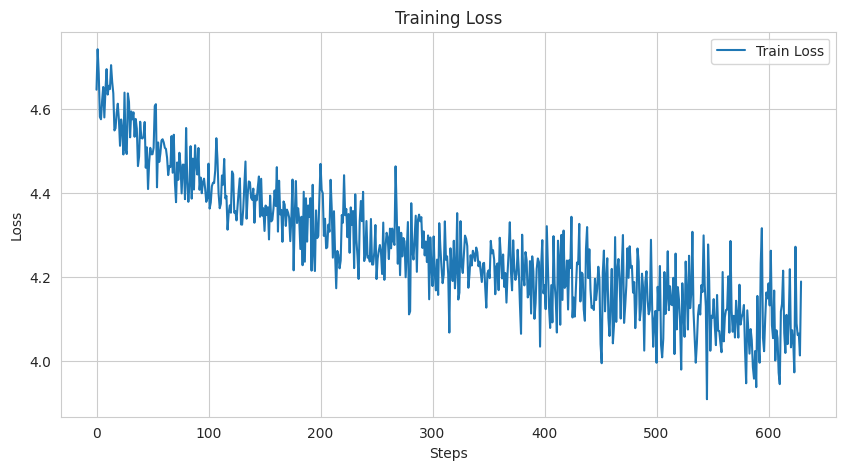

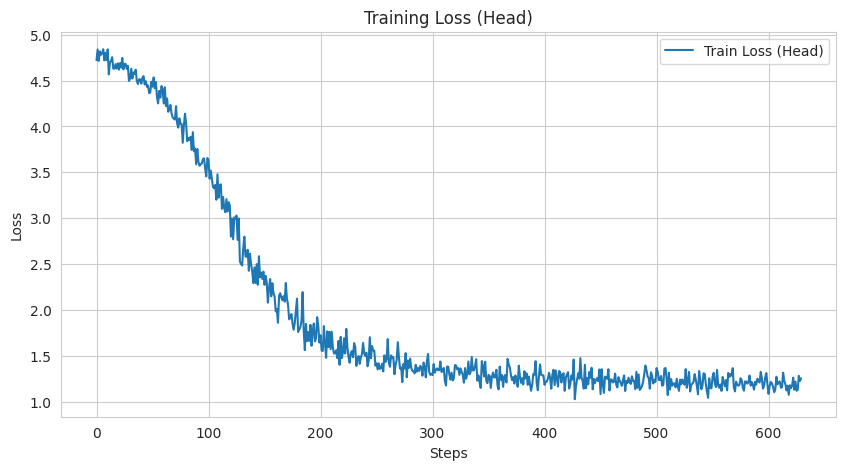

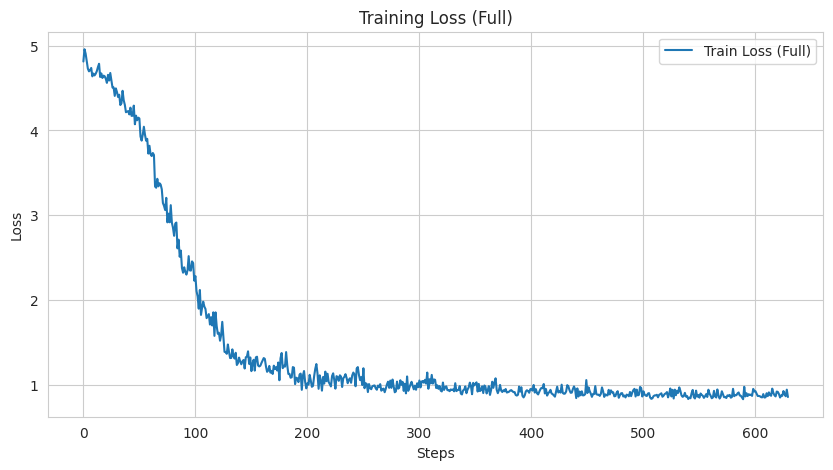

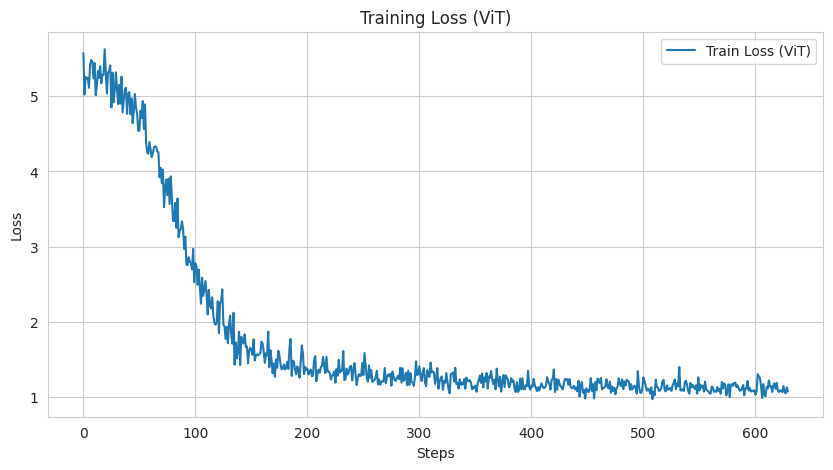

In [42]:

import matplotlib.pyplot as plt

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_losses_head, label='Train Loss (Head)')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss (Head)')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_losses_full, label='Train Loss (Full)')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss (Full)')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_losses_vit, label='Train Loss (ViT)')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss (ViT)')
plt.legend()
plt.show()



## Evaluación de Modelos Preentrenados vs. Entrenados desde Cero en Caltech-101

Esta asignación comparó el desempeño de redes neuronales entrenadas desde cero con modelos preentrenados adaptados al conjunto de datos Caltech-101 (filtrado a clases con 100 imágenes o menos). Se entrenaron varios modelos bajo diferentes configuraciones para analizar su rendimiento, eficiencia y capacidad de generalización.

### 1. ResNet34 con cabeza lineal

Se utilizó una ResNet34 preentrenada en ImageNet, entrenando únicamente su capa final (cabeza lineal). Esta configuración, con aproximadamente 46 mil parámetros entrenables, alcanzó una precisión en el conjunto de prueba de 0.920 tras solo 10 épocas. El resultado indica una transferencia efectiva de representaciones, incluso sin modificar el backbone.

### 2. Fine-tuning completo de ResNet34

Posteriormente, se entrenó la totalidad de la ResNet34, aumentando los parámetros entrenables a más de 21 millones. Esta variante alcanzó una precisión de 0.948. Aunque la mejora respecto al modelo con cabeza fija fue moderada, el ajuste completo permitió capturar mejor las características del nuevo dominio.

### 3. ViT-Small con cabeza ajustada

Se evaluó también un Vision Transformer (ViT-Small) preentrenado, ajustando solo su cabeza. Este modelo alcanzó una precisión de 0.878, por debajo de ambos experimentos con ResNet34. Este resultado sugiere que ViT podría requerir más datos o entrenamiento para aprovechar su capacidad representacional, mostrando menor eficiencia en entornos de datos limitados.

### 4. Distillation con ResNet50 y modelo pequeño

Se aplicó distillation utilizando una ResNet50 preentrenada y congelada como maestro, y una red convolucional pequeña como estudiante. El estudiante fue entrenado usando una combinación de cross-entropy y divergencia de Kullback-Leibler respecto a las salidas del maestro. El modelo resultante logró una precisión de 0.372, significativamente superior a la obtenida al entrenar la misma arquitectura desde cero (0.108). Este experimento evidencia el valor de distillation para transferir conocimiento a modelos compactos.

### 5. Observaciones generales

Todos los modelos preentrenados superaron el 90% de precisión en las primeras 10 épocas. En contraste, el modelo desde cero no superó el 10% en ese mismo periodo. No se observaron signos de sobreajuste, probablemente debido al uso de técnicas como label smoothing, regularización con weight decay y el scheduler OneCycleLR. Además, el uso de `GradScaler` y entrenamiento en precisión mixta permitió mantener eficiencia sin problemas numéricos.

### Conclusión

Los modelos preentrenados no solo alcanzaron mejores resultados, sino que lo hicieron con mayor eficiencia computacional y en menor tiempo. Las técnicas de distillation también demostraron ser útiles para transferir conocimiento a arquitecturas más pequeñas, lo cual es relevante cuando existen restricciones de recursos o de inferencia.



### Adicionalmente, se implementaron técnicas de data augmentation avanzadas como Mixup y CutMix, así como Knowledge Distillation utilizando un modelo teacher (ResNet-50) para guiar el entrenamiento de un modelo student más liviano.

In [ ]:
def mixup_cutmix(data, targets, alpha=1.0, prob=0.5):
    if random.random() >= prob:
        return data, targets
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(data.size(0), device=data.device)
    shuffled = data[idx]
    y_shuf = targets[idx]
    if random.random() < 0.5:
        data = lam * data + (1 - lam) * shuffled
        targets = (targets, y_shuf, lam)
    else:
        _, H, W = data.shape[1:]
        cut_rat = np.sqrt(1 - lam)
        cut_w = int(W * cut_rat)
        cut_h = int(H * cut_rat)
        cx = np.random.randint(W)
        cy = np.random.randint(H)
        x1 = np.clip(cx - cut_w//2, 0, W)
        y1 = np.clip(cy - cut_h//2, 0, H)
        x2 = np.clip(cx + cut_w//2, 0, W)
        y2 = np.clip(cy + cut_h//2, 0, H)
        data[:, :, y1:y2, x1:x2] = shuffled[:, :, y1:y2, x1:x2]
        targets = (targets, y_shuf, lam)
    return data, targets

def loss_mixup_cutmix(output, targets, loss_fn):
    t1, t2, lam = targets
    return lam * loss_fn(output, t1) + (1 - lam) * loss_fn(output, t2)


In [ ]:
teacher, _ = initialize_model('resnet50', num_classes=NUM_CLASSES, finetune_entire_model=False)
teacher = teacher.to(device).eval()
for p in teacher.parameters(): p.requires_grad = False

student = Model(num_classes=NUM_CLASSES).to(device)
optimizer_s = AdamW(student.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler_s = OneCycleLR(optimizer_s, max_lr=1e-3, total_steps=num_epochs * len(train_loader), pct_start=0.3)
scaler_s = torch.amp.GradScaler()
T = 4.0; alpha_kd = 0.5

for epoch in range(num_epochs):
    student.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer_s.zero_grad()
        with torch.amp.autocast(device_type='cuda'):
            out_s = student(x)
            with torch.no_grad():
                out_t = teacher(x)
            loss_kd = F.kl_div(
                F.log_softmax(out_s / T, dim=1),
                F.softmax(out_t / T, dim=1),
                reduction='batchmean'
            ) * (T * T)
            loss_ce = loss_fn(out_s, y)
            loss = alpha_kd * loss_kd + (1 - alpha_kd) * loss_ce
        scaler_s.scale(loss).backward()
        scaler_s.step(optimizer_s)
        scaler_s.update()
        scheduler_s.step()


In [ ]:
model_cn = timm.create_model('convnext_tiny', pretrained=True, num_classes=NUM_CLASSES)
for p in model_cn.parameters():
    p.requires_grad = False
model_cn.classifier = torch.nn.Linear(model_cn.classifier.in_features, NUM_CLASSES)
for p in model_cn.classifier.parameters():
    p.requires_grad = True
model_cn = model_cn.to(device)

optimizer_cn = AdamW(model_cn.classifier.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler_cn = OneCycleLR(optimizer_cn, max_lr=1e-3, total_steps=num_epochs*len(train_loader), pct_start=0.3)

model_cn.train()
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer_cn.zero_grad()
        outputs = model_cn(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer_cn.step()
        scheduler_cn.step()

model_cn.eval()
correct, total = 0, 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        preds = model_cn(x).argmax(dim=1)
        correct += (preds == y).sum().item()
        total += x.size(0)
print(correct/total)


In [ ]:
train_losses_kd, val_losses_kd = [], []
train_accs_kd, val_accs_kd   = [], []

for epoch in range(num_epochs):
    student.train()
    running_loss, running_correct, running_total = 0.0, 0, 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer_s.zero_grad()
        with torch.amp.autocast(device_type='cuda'):
            out_s = student(inputs)
            out_t = teacher(inputs)
            loss_kd = F.kl_div(
                F.log_softmax(out_s / T, dim=1),
                F.softmax(out_t / T, dim=1),
                reduction='batchmean'
            ) * (T * T)
            loss_ce = loss_fn(out_s, targets)
            loss    = alpha_kd * loss_kd + (1 - alpha_kd) * loss_ce
        scaler_s.scale(loss).backward()
        scaler_s.step(optimizer_s)
        scaler_s.update()
        if scheduler_s.last_epoch < scheduler_s.total_steps:
            scheduler_s.step()
        preds = out_s.argmax(dim=1)
        running_loss    += loss.item() * inputs.size(0)
        running_correct += (preds == targets).sum().item()
        running_total   += inputs.size(0)
    train_losses_kd.append(running_loss / running_total)
    train_accs_kd.append(running_correct / running_total)

    student.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            out_s = student(inputs)
            l     = loss_fn(out_s, targets)
            preds = out_s.argmax(dim=1)
            val_loss    += l.item() * inputs.size(0)
            val_correct += (preds == targets).sum().item()
            val_total   += inputs.size(0)
    val_losses_kd.append(val_loss / val_total)
    val_accs_kd.append(val_correct / val_total)

student.eval()
test_correct, test_total = 0, 0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        preds = student(inputs).argmax(dim=1)
        test_correct += (preds == targets).sum().item()
        test_total   += inputs.size(0)
test_acc_kd = test_correct / test_total
print(f"Test accuracy (distillation): {test_acc_kd:.3f}")
